### Project Overview

This notebook explores the food delivery market using the Takeaway database. It includes SQL queries, Python analysis, and visualizations to answer key business questions, such as price distributions, restaurant density, top-rated pizza restaurants, and value-for-money insights. Each analysis is accompanied by actionable insights and lifestyle or cost considerations for consumers and restaurant owners.

All queries and visualizations are designed to help identify market trends, competitive opportunities, and consumer behavior, supporting data-driven decision making for both restaurant partners and delivery platform users.

### 1. What is the price distribution of menu items?

In [32]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("../data/takeaway.db")

sql_query = """
WITH price_buckets AS (
    SELECT
        CASE
            WHEN price >= 0  AND price < 5   THEN '0-5'
            WHEN price >= 5  AND price < 10  THEN '5-10'
            WHEN price >= 10 AND price < 20  THEN '10-20'
            WHEN price >= 20 AND price < 40  THEN '20-40'
            WHEN price >= 40 AND price < 80  THEN '40-80'
            ELSE '80-150'
        END AS price_range
    FROM menuItems
    WHERE price IS NOT NULL
)
SELECT
    price_range,
    COUNT(*) AS item_count,
    ROUND(
        COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (),
        2
    ) AS percentage
FROM price_buckets
GROUP BY price_range
ORDER BY
    CASE price_range
        WHEN '0-5'    THEN 1
        WHEN '5-10'   THEN 2
        WHEN '10-20'  THEN 3
        WHEN '20-40'  THEN 4
        WHEN '40-80'  THEN 5
        WHEN '80-150' THEN 6
    END;
"""

price_distribution = pd.read_sql_query(sql_query, conn)
price_distribution


,price_range,item_count,percentage
0,0-5,118044,29.29
1,5-10,101797,25.26
2,10-20,156712,38.89
3,20-40,23167,5.75
4,40-80,2507,0.62
5,80-150,786,0.20


### Visualize with seaborn / matplotlib

In [33]:
import plotly.express as px

blue_palette = [
    "#08306B",  
    "#08519C",
    "#2171B5",
    "#4292C6",
    "#6BAED6",
    "#9ECAE1"   
]

fig = px.bar(
    price_distribution,
    x="price_range",
    y="item_count",
    text="percentage",
    labels={
        "price_range": "Price Range",
        "item_count": "Number of Items"
    },
    title="Price Distribution of Menu Items",
    color="price_range",
    color_discrete_sequence=blue_palette
)

fig.update_traces(
    texttemplate="%{text}%",
    textposition="outside"
)

fig.update_layout(
    xaxis_title="Price Range",
    yaxis_title="Number of Items",
    showlegend=False,
    uniformtext_minsize=10,
    uniformtext_mode="hide"
)

fig.show()





### Insight 
The delivery market is dominated by affordable meals, with nearly 93% of menu items priced below 20, indicating a strongly price-sensitive customer base.

### Actionable business recommendation
Restaurants that want to increase their margins can focus on the 10–20 price range, where most customer demand already exists, and adjust portion size or quality within this range rather than raising prices beyond what customers typically expect.

### Additional insight for cost planning 
People calculating living expenses in a new country—like migrants or students—can use takeaway meals in this price range (mostly under €20) as a benchmark for affordable daily meals, helping them plan their food budget realistically.

### 2. What is the distribution of restaurants per location?

In [21]:
import sqlite3
import pandas as pd

# 1️⃣ Connect to the database
conn = sqlite3.connect("../data/takeaway.db")

# 2️⃣ SQL query to get restaurant count per city
sql_query_restaurants = """
SELECT
    locations.city,
    COUNT(DISTINCT restaurants.restaurant_id) AS restaurant_count
FROM locations
JOIN locations_to_restaurants
    ON locations.ID = locations_to_restaurants.location_id
JOIN restaurants
    ON locations_to_restaurants.restaurant_id = restaurants.primarySlug
GROUP BY locations.city
ORDER BY restaurant_count DESC;
"""

# 3️⃣ Run the query in pandas
restaurants_per_city = pd.read_sql_query(sql_query_restaurants, conn)

# 4️⃣ Inspect the first few rows
restaurants_per_city.head(10)


,city,restaurant_count
0,Antwerp,746
1,Haren,605
2,Ghent,377
3,Zaventem,306
4,Destelbergen,284
5,Dilbeek,268
6,Drogenbos,255
7,Sint-Ulriks-Kapelle,253
8,Sint-Martens-Bodegem,252
9,Mortsel,251


In [22]:
import plotly.express as px

fig = px.bar(
    top_cities,
    x='restaurant_count',
    y='city',
    orientation='h',
    color='restaurant_count',
    color_continuous_scale='Viridis',
    title="Top 10 Cities by Number of Restaurants"
)
fig.show()


### Insight
A few cities dominate the restaurant market: Antwerp (746), Haren (605), and Ghent (377). These top cities account for a large share of the total restaurants.

### Actionable business recommendation
New or smaller restaurants in these cities will face tough competition. To stand out, they should focus on what makes them unique—such as special dishes, high‑quality ingredients, fast delivery, or loyalty programs—rather than simply trying to compete on sheer numbers. Consulting companies can support prospective owners with advanced market research and tailored planning, helping them choose the right strategies and avoid costly mistakes.

### Cost/lifestyle insight
In big cities, you have plenty of takeaway options and often good deals. Take the time to explore—you might find a favorite spot or try a new cuisine—but check prices and reviews first to make sure you get the best value.


In [23]:
# Group cities by restaurant_count
grouped_cities = low_restaurants.groupby('restaurant_count')['city'].apply(list)

# Print the cities in each group
for count, cities in grouped_cities.items():
    print(f"\nCities with {count} restaurant(s) ({len(cities)} cities):")
    print(", ".join(cities))



Cities with 1 restaurant(s) (12 cities):
Woesten, Westvleteren, Watou, Watervliet, Waterland-Oudeman, Roesbrugge-Haringe, Reninge, Proven, Pollinkhove, Oostvleteren, Noordschote, Lo

Cities with 2 restaurant(s) (7 cities):
Sint-Margriete, Sint-Jan-in-Eremo, Middelburg, Merkem, Loker, Klerken, Dranouter

Cities with 3 restaurant(s) (3 cities):
Sint-Kornelis-Horebeke, Meerle, Houthulst

Cities with 4 restaurant(s) (5 cities):
Westouter, Teuven, Remersdaal, Mesen, Meensel-Kiezegem

Cities with 5 restaurant(s) (9 cities):
Wulvergem, Woumen, Waanrode, Vladslo, Leke, Keiem, Diksmuide, Bellem, Beerst


In [20]:
import plotly.express as px
import pandas as pd

# Filter cities with 1 to 5 restaurants
low_restaurants = restaurants_per_city[restaurants_per_city['restaurant_count'].isin([1, 2, 3, 4, 5])]

# Group cities by restaurant_count
grouped_cities = low_restaurants.groupby('restaurant_count')['city'].apply(list)

# Prepare data for visualization
data = {
    'restaurant_count': [],
    'city_names': [],
    'num_cities': []
}

for count, cities in grouped_cities.items():
    data['restaurant_count'].append(count)
    data['city_names'].append(", ".join(cities))  # list of cities as text
    data['num_cities'].append(len(cities))

df_vis = pd.DataFrame(data)

# Create horizontal bar chart
fig = px.bar(
    df_vis,
    x='num_cities',
    y='restaurant_count',
    orientation='h',
    text='city_names',  # show city names on bars
    color='restaurant_count',
    color_discrete_sequence=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#99ffcc'],
    title="Cities Grouped by Number of Restaurants (1 to 5)"
)

fig.update_layout(
    yaxis_title="Number of Restaurants in City",
    xaxis_title="Number of Cities",
    yaxis=dict(tickmode='array', tickvals=[1,2,3,4,5])
)

fig.show()



### Insight
Many smaller towns have very few restaurants, with 12 towns having only 1, 7 towns with 2, 3 towns with 3, 5 towns with 4, and 9 towns with 5 restaurants. These towns are largely underserved in terms of dining options.

### Actionable Recommendation
These towns should be the first to explore for opening new restaurants, especially those offering delivery. Local restaurants can capture the market by focusing on quality, consistent service, and niche offerings, as competition is very low.

### Lifestyle / Cost Tip
Residents or newcomers should plan meals carefully in these areas. Take time to explore the few local options, try new cuisines, and check opening hours or menus in advance to get the best value and experience.



### 3. Which are the top 10 pizza restaurants by rating?

In [24]:
import sqlite3
import pandas as pd


conn = sqlite3.connect("../data/takeaway.db")


sql_query_top_pizza = """
SELECT DISTINCT
    restaurants.name AS restaurant_name,
    restaurants.city,
    restaurants.ratings
FROM restaurants
JOIN categories
    ON restaurants.primarySlug = categories.restaurant_id
JOIN menuItems
    ON categories.item_id = menuItems.id
WHERE
    restaurants.ratings IS NOT NULL
    AND LOWER(menuItems.name) LIKE '%pizza%'
ORDER BY restaurants.ratings DESC
LIMIT 10;
"""


top_pizza_restaurants = pd.read_sql_query(sql_query_top_pizza, conn)


top_pizza_restaurants


,restaurant_name,city,ratings
0,Kebap - Pizza De Brug,Hasselt,5.0
1,De Echte Eethuis Carlos,Aarschot,5.0
2,Munchies Ieper,Ieper,5.0
3,Trend Kebab & Pizzeria,Maaseik,5.0
4,La Trinacria Bottega,Woluwe-Saint-Lambert,5.0
5,Snack-It,Turnhout,5.0
6,Pizza Leie,Waregem,4.9
7,The Black Horse,Heist-op-den-Berg,4.9
8,Pyramide,Hamont,4.9
9,Baskent Meerhout,Meerhout,4.9


### Optimized code-include only restaurants with at least 25 reviews 

In [24]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("../data/takeaway.db")

sql_query_top_pizza = """
SELECT DISTINCT
    restaurants.name AS restaurant_name,
    restaurants.city,
    restaurants.ratings,
    restaurants.ratingsNumber
FROM restaurants
JOIN categories
    ON restaurants.primarySlug = categories.restaurant_id
JOIN menuItems
    ON categories.item_id = menuItems.id
WHERE
    restaurants.ratings IS NOT NULL
    AND restaurants.ratingsNumber >= 25
    AND LOWER(menuItems.name) LIKE '%pizza%'
ORDER BY restaurants.ratings DESC
LIMIT 10;
"""

top_pizza_restaurants = pd.read_sql_query(sql_query_top_pizza, conn)

top_pizza_restaurants


,restaurant_name,city,ratings,ratingsNumber
0,Kebap - Pizza De Brug,Hasselt,5.0,312
1,De Echte Eethuis Carlos,Aarschot,5.0,599
2,Trend Kebab & Pizzeria,Maaseik,5.0,165
3,The Black Horse,Heist-op-den-Berg,4.9,127
4,Pyramide,Hamont,4.9,45
5,Baskent Meerhout,Meerhout,4.9,879
6,More pizza's,Merksem,4.9,311
7,Pizzeria Zirar Saint-Denis,Forest,4.9,529
8,Royal Donuts & Bagels,Lokeren,4.9,32
9,Pizza L'Esta,Hoboken,4.9,372


### Impact of Optimization on Top Pizza Restaurants   

#### Optimization:- 
Adding a filter to include only restaurants with at least 25 reviews (ratingsNumber >= 25).

#### Differences in results

The number of restaurants with perfect 5.0 ratings decreased from 6 to 3.

Some highly-rated restaurants with very few reviews (e.g., Munchies Ieper, La Trinacria Bottega, Snack-It) were removed.

New restaurants with slightly lower ratings (4.9) but more reviews (e.g., More pizza's, Pizzeria Zirar Saint-Denis) were added.

#### Difference in interpretation
The optimized list is more reliable and trustworthy because it reflects restaurants that are both highly rated and widely reviewed, reducing the impact of outliers with very few ratings and giving a better picture of popular, consistently rated pizza restaurants.

### Top 10 Most-Reviewed Pizza Restaurants

In [26]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect("../data/takeaway.db")

# SQL query to get top 10 pizza restaurants by number of reviews
sql_query_top_pizza_by_reviews = """
SELECT DISTINCT
    restaurants.name AS restaurant_name,
    restaurants.city,
    restaurants.ratings,
    restaurants.ratingsNumber
FROM restaurants
JOIN categories
    ON restaurants.primarySlug = categories.restaurant_id
JOIN menuItems
    ON categories.item_id = menuItems.id
WHERE
    restaurants.ratings IS NOT NULL
    AND restaurants.ratingsNumber IS NOT NULL
    AND LOWER(menuItems.name) LIKE '%pizza%'
ORDER BY restaurants.ratingsNumber DESC
LIMIT 10;
"""

# Run the query in pandas
top_pizza_restaurants_by_reviews = pd.read_sql_query(sql_query_top_pizza_by_reviews, conn)

# Display the results
top_pizza_restaurants_by_reviews

,restaurant_name,city,ratings,ratingsNumber
0,Sezer Snack-Pizza,Gent,4.4,10368
1,Pizza Talia Original,Aalst,3.3,7391
2,Sim Pizza,Gent,4.5,7030
3,Pizza Company Antwerpen,Antwerpen,3.8,6895
4,BE-JACKS,Sint-Niklaas,4.5,5674
5,Pizza Yavuz,Sint-Amandsberg,4.0,5261
6,Pizza Di Trevi,Brugge,4.7,4902
7,Pizza Talia Original,Ninove,4.1,4654
8,Arrivero,Schaerbeek,4.2,4284
9,Maxx Pizza,Herentals,4.0,4217


### Top 10 Most-Reviewed Pizza Restaurants with Rating ≥ 4.5

In [27]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect("../data/takeaway.db")

# SQL query to get top 10 pizza restaurants by number of reviews with rating >= 4.5
sql_query_top_pizza_high_rating = """
SELECT DISTINCT
    restaurants.name AS restaurant_name,
    restaurants.city,
    restaurants.ratings,
    restaurants.ratingsNumber
FROM restaurants
JOIN categories
    ON restaurants.primarySlug = categories.restaurant_id
JOIN menuItems
    ON categories.item_id = menuItems.id
WHERE
    restaurants.ratings IS NOT NULL
    AND restaurants.ratings >= 4.5
    AND restaurants.ratingsNumber IS NOT NULL
    AND LOWER(menuItems.name) LIKE '%pizza%'
ORDER BY restaurants.ratingsNumber DESC
LIMIT 10;
"""

# Run the query in pandas
top_pizza_restaurants_high_rating = pd.read_sql_query(sql_query_top_pizza_high_rating, conn)

# Display the results
top_pizza_restaurants_high_rating


,restaurant_name,city,ratings,ratingsNumber
0,Sim Pizza,Gent,4.5,7030
1,BE-JACKS,Sint-Niklaas,4.5,5674
2,Pizza Di Trevi,Brugge,4.7,4902
3,Pizza Service,Mechelen,4.5,4147
4,Cesars,Putte,4.7,3632
5,Pizza Vera,Vilvorde,4.6,3349
6,Pizza Pasta Concept,Deurne,4.8,2894
7,Pizza Minute,Schaerbeek,4.9,2833
8,Pizza Pronto,Blankenberge,4.5,2578
9,Pizza Altamira,Bruxelles,4.5,2542




## Final Selected Restaurants

##### Most-reviewed pizza restaurants with a rating of at least 4.5

**Sim Pizza** (Gent, 4.5, 7,030 reviews) 
https://www.simpizza.be/ 

**BE-JACKS** (Sint-Niklaas, 4.5, 5,674 reviews)
https://www.bejacks.be/ 

**Pizza Di Trevi** (Brugge, 4.7, 4,902 reviews) 
https://brugge.pizzaditrevi.be/ 

##### Highest-rated pizza restaurants with at least 100 reviews

**De Echte Eethuis Carlos** (Aarschot, 5.0, 599 reviews) 

**Kebap - Pizza De Brug** (Hasselt, 5.0, 312 reviews)

**Trend Kebab & Pizzeria** (Maaseik, 5.0, 165 reviews)


##### -**Note: Fact Check for one restaurant**
**Sim Pizza** (Gent)

-Data analysis:  (4.5, 7,030 reviews) 

-Takeaway.com website: (4.6, 8.300+ reviews)

-Restaurant website: (4.1,586 reviews)

*prices were almost same on Takeaway.com and Restaurant website; however, you see promotions on Takeaway.com.  

### Critical Analysis of the four code-blocks leading to the above conclusion
Summary of Top Pizza Restaurants

#### 1️⃣ First Code (Top 10 by Rating)

What it shows: The 10 highest-rated pizza restaurants, regardless of the number of reviews.

Top 3 restaurants:

Kebap - Pizza De Brug (Hasselt, 5.0)

De Echte Eethuis Carlos (Aarschot, 5.0)

Munchies Ieper (Ieper, 5.0)

#### 2️⃣ Second Code (Top 10 by Rating with ≥25 Reviews)

What it shows: Highest-rated pizza restaurants with at least 25 reviews, to ensure reliability.

Top 3 restaurants:

Kebap - Pizza De Brug (Hasselt, 5.0, 312 reviews)

De Echte Eethuis Carlos (Aarschot, 5.0, 599 reviews)

Trend Kebab & Pizzeria (Maaseik, 5.0, 165 reviews)

#### 3️⃣ Third Code (Top 10 by Number of Reviews)

What it shows: Pizza restaurants with the most reviews, regardless of rating.

Top 3 restaurants:

Sezer Snack-Pizza (Gent, 4.4, 10,368 reviews)

Pizza Talia Original (Aalst, 3.3, 7,391 reviews)

Sim Pizza (Gent, 4.5, 7,030 reviews)

#### 4️⃣ Fourth Code (Top 10 by Number of Reviews, Rating ≥4.5)

What it shows: Most-reviewed pizza restaurants with a rating of at least 4.5.

Top 3 restaurants:

Sim Pizza (Gent, 4.5, 7,030 reviews)

BE-JACKS (Sint-Niklaas, 4.5, 5,674 reviews)

Pizza Di Trevi (Brugge, 4.7, 4,902 reviews)

### 4. Map locations offering  your favorite dish(burgers) and their average price.

In [28]:
import sqlite3
import pandas as pd

# 1️⃣ Connect to database
conn = sqlite3.connect("../data/takeaway.db")

# 2️⃣ SQL query to get average burger price and number of burger restaurants per city
sql_query_burgers = """
SELECT
    locations.city,
    locations.latitude,
    locations.longitude,
    AVG(menuItems.price) AS average_burger_price,
    COUNT(DISTINCT restaurants.primarySlug) AS number_of_burger_restaurants
FROM restaurants
JOIN categories
    ON restaurants.primarySlug = categories.restaurant_id
JOIN menuItems
    ON categories.item_id = menuItems.id
JOIN locations_to_restaurants
    ON restaurants.primarySlug = locations_to_restaurants.restaurant_id
JOIN locations
    ON locations_to_restaurants.location_id = locations.ID
WHERE
    LOWER(categories.name) LIKE '%burger%'
    AND menuItems.price IS NOT NULL
GROUP BY
    locations.city,
    locations.latitude,
    locations.longitude
ORDER BY
    average_burger_price DESC;
"""

# 3️⃣ Run the query in pandas
burger_data = pd.read_sql_query(sql_query_burgers, conn)

# 4️⃣ Inspect the first rows
burger_data.head(20)


,city,latitude,longitude,average_burger_price,number_of_burger_restaurants
0,L'Écluse,50.771413,4.832226,20.187500,1
1,Lo,50.979774,2.749610,18.250000,1
2,Lo,50.980950,2.748760,18.250000,1
3,Noordschote,50.955238,2.810721,18.250000,1
4,Oostvleteren,50.933785,2.741783,18.250000,1
5,Pollinkhove,50.970816,2.733174,18.250000,1
6,Reninge,50.947662,2.789880,18.250000,1
7,Westvleteren,50.896177,2.721362,18.250000,1
8,Westvleteren,50.927476,2.717558,18.250000,1
9,Woesten,50.900635,2.790450,18.250000,1


In [49]:
import plotly.express as px

# 1️⃣ Filter for Belgium cities (approximate bounding box)
# Belgium roughly: latitude 49.5–51.5, longitude 2.5–6.5
burger_data_be = burger_data[
    (burger_data['latitude'] >= 49.5) & (burger_data['latitude'] <= 51.5) &
    (burger_data['longitude'] >= 2.5) & (burger_data['longitude'] <= 6.5)
]

# 2️⃣ Create map
fig = px.scatter_mapbox(
    burger_data_be,
    lat="latitude",
    lon="longitude",
    size="number_of_burger_restaurants",   # bubble size = number of burger restaurants
    color="average_burger_price",          # color = average price
    color_continuous_scale="Viridis",
    hover_name="city",
    hover_data={"latitude":False, "longitude":False, 
                "average_burger_price":":.2f", 
                "number_of_burger_restaurants":True},
    zoom=7,        # zoom closer to Belgium
    size_max=30,
    mapbox_style="carto-positron",
    title="Burger Restaurants and Average Price by City (Belgium)"
)
fig.show()



C:\Users\Hamideh\AppData\Local\Temp\ipykernel_20372\1231873786.py:11: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



### Burger Price vs Restaurant Count per City (Outliers Removed)

Correlation (excluding outliers) between average burger price and number of burger restaurants: 0.20


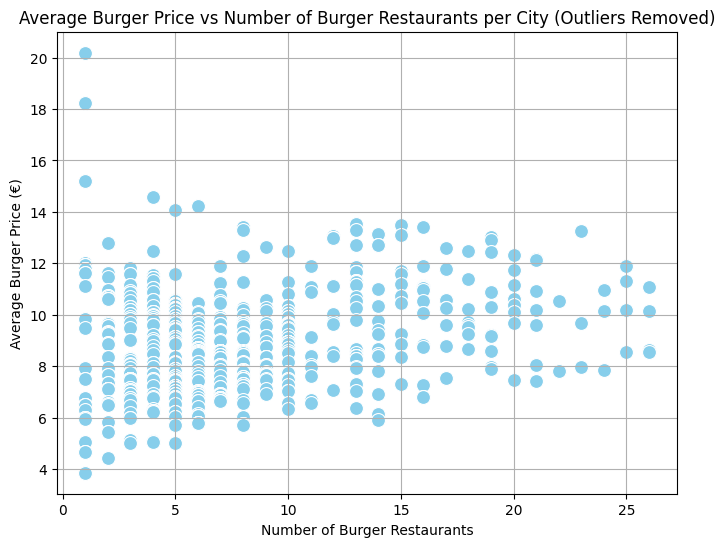

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# 1️⃣ Connect to the database
conn = sqlite3.connect("../data/takeaway.db")

# 2️⃣ SQL query to get average burger price and number of burger restaurants per city
sql_query_burgers = """
SELECT
    locations.city,
    AVG(menuItems.price) AS average_burger_price,
    COUNT(DISTINCT restaurants.primarySlug) AS number_of_burger_restaurants
FROM restaurants
JOIN categories
    ON restaurants.primarySlug = categories.restaurant_id
JOIN menuItems
    ON categories.item_id = menuItems.id
JOIN locations_to_restaurants
    ON restaurants.primarySlug = locations_to_restaurants.restaurant_id
JOIN locations
    ON locations_to_restaurants.location_id = locations.ID
WHERE
    LOWER(categories.name) LIKE '%burger%'
    AND menuItems.price IS NOT NULL
GROUP BY
    locations.city
ORDER BY
    average_burger_price DESC;
"""

# 3️⃣ Load data
burger_data = pd.read_sql_query(sql_query_burgers, conn)

# 4️⃣ Remove outliers in number of restaurants using IQR
Q1 = burger_data['number_of_burger_restaurants'].quantile(0.25)
Q3 = burger_data['number_of_burger_restaurants'].quantile(0.75)
IQR = Q3 - Q1

# Keep only cities within 1.5*IQR
filtered_data = burger_data[
    (burger_data['number_of_burger_restaurants'] >= Q1 - 1.5*IQR) &
    (burger_data['number_of_burger_restaurants'] <= Q3 + 1.5*IQR)
]

# 5️⃣ Calculate correlation on filtered data
correlation = filtered_data['average_burger_price'].corr(filtered_data['number_of_burger_restaurants'])
print(f"Correlation (excluding outliers) between average burger price and number of burger restaurants: {correlation:.2f}")

# 6️⃣ Visualize the relationship
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=filtered_data,
    x='number_of_burger_restaurants',
    y='average_burger_price',
    s=100,
    color='skyblue'
)
plt.title("Average Burger Price vs Number of Burger Restaurants per City (Outliers Removed)")
plt.xlabel("Number of Burger Restaurants")
plt.ylabel("Average Burger Price (€)")
plt.grid(True)
plt.show()



### Insight

Single-restaurant cities dominate the top average prices. Small towns (e.g., L'Écluse, Lo, Oostvleteren, Westvleteren) have only 1 burger restaurant, with prices around €18–€20, showing that low competition allows higher pricing.

### Actionable Plan

If opening a restaurant in these towns, focus on high-quality ingredients, unique menu items, and reliable service. With limited competition, these restaurants can achieve strong success.

### Lifestyle/Cost Planning Insights

Residents in single-restaurant towns should expect higher prices for takeaway burgers. In cities with more burger options, people can compare prices and find better deals, making meal planning more budget-friendly.

### 5. Which restaurants have the best price-to-rating ratio?

In [50]:
import sqlite3
import pandas as pd

# Connect to database
conn = sqlite3.connect("../data/takeaway.db")

# SQL query: value-for-money restaurants
sql_query_value_for_money = """
SELECT
    restaurants.name AS restaurant_name,
    restaurants.city,
    restaurants.ratings,
    restaurants.ratingsNumber,
    AVG(menuItems.price) AS average_menu_price,
    AVG(menuItems.price) / restaurants.ratings AS price_to_rating_ratio
FROM restaurants
JOIN categories
    ON restaurants.primarySlug = categories.restaurant_id
JOIN menuItems
    ON categories.item_id = menuItems.id
WHERE
    restaurants.ratings IS NOT NULL
    AND restaurants.ratings > 0
    AND restaurants.ratingsNumber >= 25
    AND menuItems.price IS NOT NULL
GROUP BY
    restaurants.name,
    restaurants.city,
    restaurants.ratings,
    restaurants.ratingsNumber
HAVING
    AVG(menuItems.price) > 0
ORDER BY
    price_to_rating_ratio ASC
LIMIT 10;
"""

# Run query and load into DataFrame
value_for_money_df = pd.read_sql_query(sql_query_value_for_money, conn)

# Inspect results
value_for_money_df


,restaurant_name,city,ratings,ratingsNumber,average_menu_price,price_to_rating_ratio
0,El Bocadillos,Bruxelles,4.2,307,2.000000,0.476190
1,Frituur Amigos,Wilrijk,4.3,1172,2.411765,0.560876
2,QueTacos,Maasmechelen,5.0,157,2.857143,0.571429
3,Frituur 4 You,Vilvorde,4.7,220,2.690471,0.572441
4,Say Pasta,Antwerpen,4.6,59,2.712609,0.589698
5,Street'Tacos,Waregem,3.9,47,2.382353,0.610860
6,Rumah Jawa,Rillaar,4.8,32,3.000000,0.625000
7,La Friterie Red,Anderlecht,4.1,536,2.581081,0.629532
8,Frituur Permeke,Wilrijk,4.6,985,2.903279,0.631148
9,Frituur 't Koxke,Antwerpen,4.3,476,2.752869,0.640202


In [52]:
import plotly.express as px

fig = px.bar(
    value_for_money_df,
    x="price_to_rating_ratio",
    y="restaurant_name",
    orientation="h",
    color="average_menu_price",
    color_continuous_scale="Viridis",
    hover_data={
        "city": True,
        "ratings": True,
        "ratingsNumber": True,
        "average_menu_price": ":.2f",
        "price_to_rating_ratio": ":.2f"
    },
    title="Top 10 Restaurants by Value for Money (Lowest Price-to-Rating Ratio)"
)

fig.update_layout(
    yaxis_title="Restaurant",
    xaxis_title="Price-to-Rating Ratio",
    yaxis=dict(autorange="reversed")  # best value at the top
)

fig.show()


### Insight

The price-to-rating ratio shows which restaurants give the best value for money: lower values indicate higher ratings relative to price.

### Actionable Plan

New entrants can use this ratio to benchmark pricing, balancing menu price and expected rating to stay competitive.

### Lifestyle/Cost Tip

Customers can choose wisely: low ratios for budget-friendly options, higher ratios for premium quality at a higher price.

### 6. Where are the delivery 'dead zones'—areas with minimal restaurant coverage?

In [10]:
import sqlite3
import pandas as pd

# Connect to database
conn = sqlite3.connect("../data/takeaway.db")

# SQL query: postal codes with minimal restaurant coverage
sql_query_low_coverage = """
SELECT
    l.city,
    l.postalCode,
    COUNT(DISTINCT r.primarySlug) AS restaurant_count
FROM locations l
LEFT JOIN locations_to_restaurants lr
    ON l.ID = lr.location_id
LEFT JOIN restaurants r
    ON lr.restaurant_id = r.primarySlug
WHERE
    l.postalCode IS NOT NULL
    AND l.postalCode != 0
GROUP BY
    l.city,
    l.postalCode
HAVING
    restaurant_count <= 1
ORDER BY
    restaurant_count ASC,
    l.city,
    l.postalCode;
"""

# Run query and load into DataFrame
low_coverage_df = pd.read_sql_query(sql_query_low_coverage, conn)

print(f"Number of low-coverage city–postcode rows: {len(low_coverage_df)}")

# Inspect results
low_coverage_df.head()


Number of low-coverage city–postcode rows: 16


,city,postalCode,restaurant_count
0,Alveringem,8690,0
1,Alveringem,8691,0
2,Sint-Eloois-Vijve,8193,0
3,Lo,8647,1
4,Noordschote,8647,1


In [18]:
import plotly.express as px

# Aggregate postal codes per city as a comma-separated string
city_counts = (
    low_coverage_df.groupby("city", as_index=False)
    .agg(
        low_coverage_postcodes_count=("postalCode", "count"),
        postal_codes=("postalCode", lambda x: ", ".join(map(str, x)))
    )
)

# Create interactive pie chart
fig = px.pie(
    city_counts,
    names="city",
    values="low_coverage_postcodes_count",
    title="Distribution of Low-Coverage Postal Codes by City (Belgium)",
    color_discrete_sequence=px.colors.qualitative.Pastel,
    custom_data=["postal_codes"]  # include postal codes for hover
)

# Show labels inside (city only) and display postal codes on hover
fig.update_traces(
    textposition='inside',
    textinfo='label',  # only show city name
    pull=[0.05]*len(city_counts),
    hovertemplate="<b>%{label}</b><br>Low-coverage postcodes: %{value}<br>Postal Codes: %{customdata[0]}"
)

# Add annotation explaining "low coverage"
fig.add_annotation(
    text="Low coverage = postal codes with 0 or 1 restaurant",
    xref="paper", yref="paper",
    x=0.5, y=-0.1,  # position below chart
    showarrow=False,
    font=dict(size=12)
)

fig.show()


### The code with latitude and longitude 

In [12]:
import sqlite3
import pandas as pd

# Connect to database
conn = sqlite3.connect("../data/takeaway.db")

# SQL query: postal codes with minimal restaurant coverage + coordinates
sql_query_low_coverage_map = """
SELECT
    l.city,
    l.postalCode,
    l.latitude,
    l.longitude,
    COUNT(DISTINCT r.primarySlug) AS restaurant_count
FROM locations l
LEFT JOIN locations_to_restaurants lr
    ON l.ID = lr.location_id
LEFT JOIN restaurants r
    ON lr.restaurant_id = r.primarySlug
WHERE l.postalCode IS NOT NULL
  AND l.postalCode != 0
  AND l.latitude IS NOT NULL
  AND l.longitude IS NOT NULL
GROUP BY
    l.city,
    l.postalCode,
    l.latitude,
    l.longitude
HAVING
    restaurant_count <= 1
ORDER BY
    restaurant_count ASC,
    l.city,
    l.postalCode;
"""

# Run query and load into DataFrame
low_coverage_df = pd.read_sql_query(sql_query_low_coverage_map, conn)

# Inspect results
low_coverage_df.head()
print(f"Number of low-coverage city-postcode rows: {len(low_coverage_df)}")


Number of low-coverage city–postcode rows: 28


### 7. How does the availability of vegetarian and vegan dishes vary by area?

In [20]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect("../data/takeaway.db")

# SQL query for vegan/vegetarian restaurants per city-postcode
sql_query_vegan_vegetarian = """
SELECT
    l.city,
    l.postalCode,
    l.latitude,
    l.longitude,
    COUNT(DISTINCT CASE 
        WHEN LOWER(c.name) LIKE '%vegan%' AND LOWER(c.name) NOT LIKE '%non vegan%' 
        THEN r.primarySlug
    END) AS restaurants_offering_vegan,
    COUNT(DISTINCT CASE 
        WHEN (LOWER(c.name) LIKE '%vegetarian%' 
              OR LOWER(c.name) LIKE '%vegetarisch%' 
              OR LOWER(c.name) LIKE '%veggies%' 
              OR LOWER(c.name) LIKE '%vegetariana%' 
              OR LOWER(c.name) LIKE '%veggi%' 
              OR LOWER(c.name) LIKE '%veggie%') 
         AND LOWER(c.name) NOT LIKE '%non vegan%' 
        THEN r.primarySlug
    END) AS restaurants_offering_vegetarian,
    COUNT(DISTINCT CASE 
        WHEN (LOWER(c.name) LIKE '%vegan%' AND LOWER(c.name) NOT LIKE '%non vegan%')
          OR (LOWER(c.name) LIKE '%vegetarian%' 
              OR LOWER(c.name) LIKE '%vegetarisch%' 
              OR LOWER(c.name) LIKE '%veggies%' 
              OR LOWER(c.name) LIKE '%vegetariana%' 
              OR LOWER(c.name) LIKE '%veggi%' 
              OR LOWER(c.name) LIKE '%veggie%') 
        THEN r.primarySlug
    END) AS restaurants_offering_vegan_or_vegetarian
FROM categories c
JOIN locations_to_restaurants lr
    ON c.restaurant_id = lr.restaurant_id
JOIN locations l
    ON lr.location_id = l.ID
JOIN restaurants r
    ON lr.restaurant_id = r.primarySlug
GROUP BY
    l.city,
    l.postalCode,
    l.latitude,
    l.longitude
ORDER BY
    restaurants_offering_vegan_or_vegetarian DESC,
    l.city,
    l.postalCode;
"""

# Load into pandas
vegan_veg_df = pd.read_sql_query(sql_query_vegan_vegetarian, conn)

# Inspect data
vegan_veg_df.head()


,city,postalCode,latitude,longitude,restaurants_offering_vegan,restaurants_offering_vegetarian,restaurants_offering_vegan_or_vegetarian
0,Antwerp,2018,51.193996,4.410126,22,83,97
1,Antwerp,2018,51.198659,4.403266,21,82,95
2,Antwerp,2018,51.199487,4.394946,21,82,95
3,Antwerp,2140,51.209830,4.452842,20,83,95
4,Antwerp,2140,51.210885,4.433730,19,84,95


In [30]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect("../data/takeaway.db")

# SQL query with total restaurants per postal code
sql_query_vegan_vegetarian = """
SELECT
    l.city,
    l.postalCode,
    l.latitude,
    l.longitude,
    COUNT(DISTINCT r.primarySlug) AS total_restaurants,
    COUNT(DISTINCT CASE 
        WHEN LOWER(c.name) LIKE '%vegan%' AND LOWER(c.name) NOT LIKE '%non vegan%' 
        THEN r.primarySlug
    END) AS restaurants_offering_vegan,
    COUNT(DISTINCT CASE 
        WHEN (LOWER(c.name) LIKE '%vegetarian%' 
              OR LOWER(c.name) LIKE '%vegetarisch%' 
              OR LOWER(c.name) LIKE '%veggies%' 
              OR LOWER(c.name) LIKE '%vegetariana%' 
              OR LOWER(c.name) LIKE '%veggi%' 
              OR LOWER(c.name) LIKE '%veggie%') 
         AND LOWER(c.name) NOT LIKE '%non vegan%' 
        THEN r.primarySlug
    END) AS restaurants_offering_vegetarian,
    COUNT(DISTINCT CASE 
        WHEN (LOWER(c.name) LIKE '%vegan%' AND LOWER(c.name) NOT LIKE '%non vegan%')
          OR (LOWER(c.name) LIKE '%vegetarian%' 
              OR LOWER(c.name) LIKE '%vegetarisch%' 
              OR LOWER(c.name) LIKE '%veggies%' 
              OR LOWER(c.name) LIKE '%vegetariana%' 
              OR LOWER(c.name) LIKE '%veggi%' 
              OR LOWER(c.name) LIKE '%veggie%') 
        THEN r.primarySlug
    END) AS restaurants_offering_vegan_or_vegetarian
FROM categories c
JOIN locations_to_restaurants lr
    ON c.restaurant_id = lr.restaurant_id
JOIN locations l
    ON lr.location_id = l.ID
JOIN restaurants r
    ON lr.restaurant_id = r.primarySlug
GROUP BY
    l.city,
    l.postalCode,
    l.latitude,
    l.longitude
ORDER BY
    restaurants_offering_vegan_or_vegetarian DESC,
    l.city,
    l.postalCode;
"""

# Load into pandas
vegan_veg_df = pd.read_sql_query(sql_query_vegan_vegetarian, conn)

# Add percentage column
vegan_veg_df["percentage_vegan_vegetarian"] = (
    vegan_veg_df["restaurants_offering_vegan_or_vegetarian"] / vegan_veg_df["total_restaurants"] * 100
).round(2)

# Inspect results
vegan_veg_df.head()


,city,postalCode,latitude,longitude,total_restaurants,restaurants_offering_vegan,restaurants_offering_vegetarian,restaurants_offering_vegan_or_vegetarian,percentage_vegan_vegetarian
0,Antwerp,2018,51.193996,4.410126,535,22,83,97,18.13
1,Antwerp,2018,51.198659,4.403266,533,21,82,95,17.82
2,Antwerp,2018,51.199487,4.394946,529,21,82,95,17.96
3,Antwerp,2140,51.209830,4.452842,534,20,83,95,17.79
4,Antwerp,2140,51.210885,4.433730,545,19,84,95,17.43


In [35]:
import plotly.express as px

# 1️⃣ Aggregate total restaurants and vegan/vegetarian restaurants per city
city_summary = (
    vegan_veg_df.groupby("city", as_index=False)
    .agg(
        total_restaurants=("total_restaurants", "sum"),
        vegan_or_vegetarian_restaurants=("restaurants_offering_vegan_or_vegetarian", "sum")
    )
)

# 2️⃣ Calculate percentage
city_summary["percentage_vegan_vegetarian"] = (
    city_summary["vegan_or_vegetarian_restaurants"] / city_summary["total_restaurants"] * 100
).round(2)

# 3️⃣ Create a label combining number and percentage
city_summary["label_text"] = city_summary.apply(
    lambda row: f"{row['vegan_or_vegetarian_restaurants']} ({row['percentage_vegan_vegetarian']}%)", axis=1
)

# 4️⃣ Select top 5 cities by number of vegan/vegetarian restaurants
top5_cities = city_summary.sort_values("vegan_or_vegetarian_restaurants", ascending=False).head(5)

# 5️⃣ Create bar chart with a discrete academic-style palette
custom_colors = ["#00274D", "#1F77B4", "#FF7F0E", "#FFBB78", "#AEC7E8"]  # dark blue, medium blue, orange, light orange, light blue

fig = px.bar(
    top5_cities,
    x="city",
    y="vegan_or_vegetarian_restaurants",
    text="label_text",  # show number + percentage
    hover_data={
        "total_restaurants": True,
        "vegan_or_vegetarian_restaurants": True,
        "percentage_vegan_vegetarian": True
    },
    labels={
        "vegan_or_vegetarian_restaurants": "Restaurants Offering Vegan/Vegetarian",
        "city": "City"
    },
    title="Top 5 Cities by Number of Restaurants Offering Vegan/Vegetarian Options (Belgium)",
    color="city",  # assign color per city
    color_discrete_sequence=custom_colors
)

# 6️⃣ Adjust text to be inside the bars
fig.update_traces(
    texttemplate="%{text}",
    textposition="inside",
    textfont_color="white"
)

fig.update_layout(
    yaxis_title="Number of Restaurants",
    xaxis_title="City",
    showlegend=False
)

fig.show()


### 8. Identify the **World Hummus Order (WHO)**; top 3 hummus serving restaurants.

In [42]:
import sqlite3
import pandas as pd

# Connect to database
conn = sqlite3.connect("../data/takeaway.db")

# SQL query: top 10 restaurants with hummus items
sql_query_hummus = """
SELECT
    r.name AS restaurant_name,
    r.city,
    COUNT(m.id) AS hummus_item_count,
    ROUND(AVG(m.price), 2) AS average_hummus_price
FROM restaurants r
JOIN menuItems m
    ON r.primarySlug = m.primarySlug
WHERE LOWER(m.name) LIKE '%hummus%' 
   OR LOWER(m.description) LIKE '%hummus%'
GROUP BY
    r.name,
    r.city
ORDER BY
    hummus_item_count DESC
LIMIT 10;
"""

# Run query and load into DataFrame
hummus_df = pd.read_sql_query(sql_query_hummus, conn)

# Just type the DataFrame name to display a neat table
hummus_df


,restaurant_name,city,hummus_item_count,average_hummus_price
0,Boker Tov,Antwerpen,12,31.50
1,Restaurant le Royal,Bruxelles-Capitale,12,15.46
2,Sesam,Kortrijk,12,13.88
3,Le Pain Quotidien,Gent,10,15.05
4,Beiruti,Gent,9,9.78
5,Mosaic,Leuven,9,14.66
6,Hot Falafel,Gent,8,10.88
7,Sufra,Antwerpen,8,28.65
8,Le Pain Quotidien,Antwerpen,7,13.66
9,Palmyra,Leuven,7,63.50


In [46]:
import sqlite3
import pandas as pd
import plotly.express as px

# Connect to database
conn = sqlite3.connect("../data/takeaway.db")

# SQL query: top 10 restaurants with hummus items
sql_query_hummus = """
SELECT
    r.name AS restaurant_name,
    r.city,
    COUNT(m.id) AS hummus_item_count,
    ROUND(AVG(m.price), 2) AS average_hummus_price
FROM restaurants r
JOIN menuItems m
    ON r.primarySlug = m.primarySlug
WHERE LOWER(m.name) LIKE '%hummus%' 
   OR LOWER(m.description) LIKE '%hummus%'
GROUP BY
    r.name,
    r.city
ORDER BY
    hummus_item_count DESC
LIMIT 10;
"""

# Run query and load into DataFrame
hummus_df = pd.read_sql_query(sql_query_hummus, conn)

# Add city to restaurant name
hummus_df['restaurant_label'] = hummus_df['restaurant_name'] + ' (' + hummus_df['city'] + ')'

# Interactive bar chart: hummus items per restaurant with average price on the bars
fig = px.bar(
    hummus_df.sort_values('hummus_item_count', ascending=False),
    x='restaurant_label',
    y='hummus_item_count',
    color='average_hummus_price',
    text='average_hummus_price',  # show avg price on bars
    hover_data=['city', 'average_hummus_price'],
    labels={'restaurant_label': 'Restaurant (City)',
            'hummus_item_count': 'Number of Hummus Items',
            'average_hummus_price': 'Avg Price (€)'},
    title='Top 10 Restaurants by Hummus Items'
)

# Ensure text is outside the bars and visible
fig.update_traces(
    texttemplate='%{text}€',
    textposition='outside',
    insidetextanchor='end'
)

# Increase y-axis range so all text fits above the bars
fig.update_layout(
    xaxis_tickangle=-45,
    template='plotly_white',
    yaxis=dict(range=[0, hummus_df['hummus_item_count'].max() * 1.2])
)

fig.show()
